# Gendist V1.0
## Rotation trenches

* Convert weights to tensorflow dataset
* Train on the full circle to get the baseline
* Use CNN already!!

In [2]:
import os
from datetime import datetime

date_str = datetime.now().strftime("%y%m%d%H%M")
path_base = f"exp-{date_str}"

path_base = os.path.join("outputs", path_base)
path_output = os.path.join(path_base, "output")
path_logs = os.path.join(path_base, "logs")

print(path_base)

outputs/exp-2203201049


In [579]:
os.mkdir(path_base)
os.mkdir(path_output)
os.mkdir(path_logs)

In [3]:
path_base = os.path.join("outputs", "exp-2203171334")
path_output = os.path.join(path_base, "output")
path_logs = os.path.join(path_base, "logs")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import jax
import optax
import dojax
import pickle
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from augly import image
from sklearn.decomposition import PCA
from flax import serialization
from multiprocessing import Pool
from loguru import logger

In [6]:
from tqdm.notebook import tqdm

In [7]:
import gendist
from gendist import training, processing, models

In [8]:
from gendist.models import MLPDataV1
from gendist.processing import flat_and_concat_params
# from gendist.training import TrainingConfig, make_cross_entropy_loss_func

In [9]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [10]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [11]:
n_classes = 10
X_train = np.array(mnist_train.data) / 255
y_train = np.array(mnist_train.targets)
y_train_ohe = jax.nn.one_hot(y_train, n_classes)

In [12]:
X_test = np.array(mnist_test.data) / 255
y_test = np.array(mnist_test.targets)

In [13]:
def processor(X, angle):
    X_shift = image.aug_np_wrapper(X, image.rotate, degrees=angle)
    size_im = X_shift.shape[0]
    size_pad = (28 - size_im) // 2
    size_pad_mod = (28 - size_im) % 2
    X_shift = np.pad(X_shift, (size_pad, size_pad + size_pad_mod))
    
    return X_shift

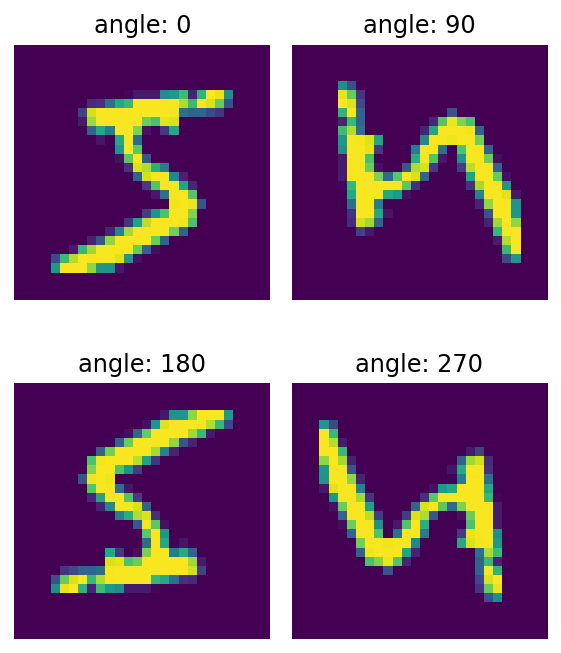

In [14]:
degrees = [0, 90, 180, 270]

fig, ax = plt.subplots(2, 2, figsize=(4, 5))
for axi, deg in zip(ax.flat, degrees):
    x_shift = processor(X_train[0], deg)
    
    axi.imshow(x_shift)
    axi.axis("off")
    axi.set_title(f"angle: {deg}")
plt.tight_layout()

In [15]:
key = jax.random.PRNGKey(314)

batch_size = 2000
n_epochs = 50
alpha = 0.001
tx = optax.adam(learning_rate=alpha)
# tx = optax.cosine_decay_schedule(0.1, 10)
model = gendist.models.MLPDataV1(n_classes)

proc_class = gendist.processing.Factory(processor)
degrees = np.r_[np.linspace(0, 90, 50), np.linspace(180, 270, 50)]

In [16]:
num_cycles = 10
epochs_per_cycle = 50
batch_size = 2_000
n_epochs = num_cycles * epochs_per_cycle
steps_per_epoch = X_train.shape[0] // batch_size
boundaries = list(np.arange(1, num_cycles + 1) * epochs_per_cycle * steps_per_epoch)
n_epochs

500

In [17]:
alphas = [0.085 * (1 - 0.01) ** n for n in range(n_epochs)]
cycle_size = epochs_per_cycle * steps_per_epoch
learning_rates = [optax.cosine_decay_schedule(alpha, cycle_size, 1e-4) for alpha in alphas]
learning_rates = optax.join_schedules(learning_rates, boundaries)

In [18]:
tx = optax.adam(learning_rates)

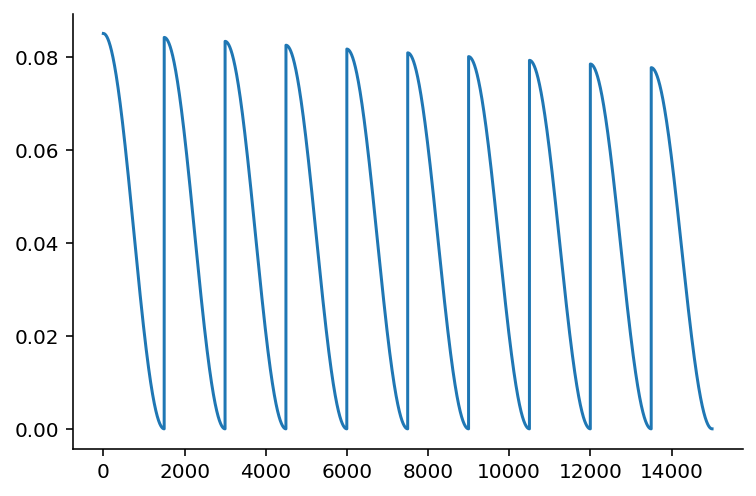

In [19]:
steps = jnp.arange(n_epochs * steps_per_epoch)
plt.plot(steps, learning_rates(steps))

In [532]:
config = {"angle": 0.0}
train_config = gendist.training.TrainingSnapshot(model, proc_class,
                              gendist.training.make_cross_entropy_loss_func, tx, epochs_per_cycle)
collection_params, losses = train_config.fit(key, X_train, y_train_ohe,
                                                    config, n_epochs, batch_size)

In [533]:
len(collection_params)

10

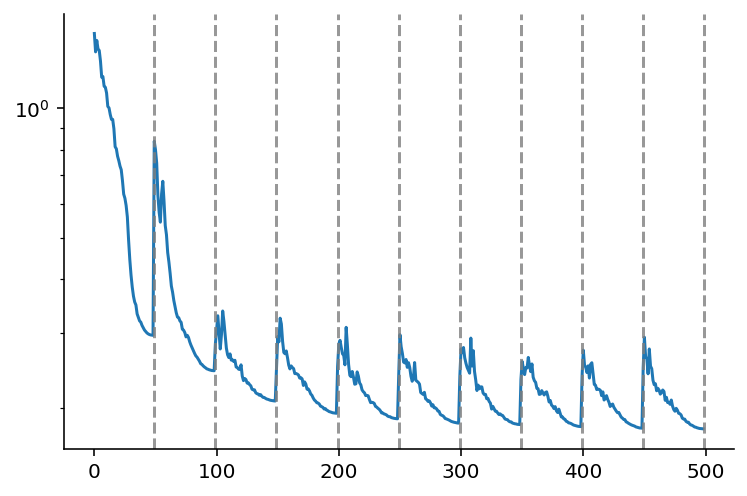

In [534]:
plt.plot(losses[1:])
for boundary in boundaries:
    plt.axvline(x=boundary / steps_per_epoch - 1, c="tab:gray", alpha=0.8, linestyle="--")
plt.yscale("log")

In [ ]:
train_config = gendist.training.TrainingSnapshot(model, proc_class,
                              gendist.training.make_cross_entropy_loss_func, tx, epochs_per_cycle)
configs_params = []
configs_losses = []

for deg in tqdm(degrees):
    config = {"angle": float(deg)}
    collection_params, losses = train_config.fit(key, X_train, y_train_ohe,
                                                        config, n_epochs, batch_size)
    configs_params.extend(collection_params)
    configs_losses.append(losses)

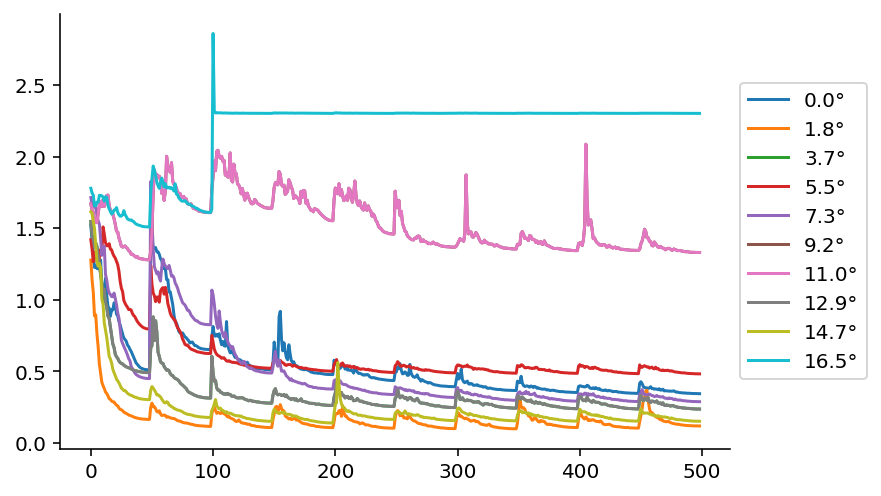

In [27]:
np.random.seed(31415)
n_configurations = len(degrees)
n_samples = 10
sample_configs = np.random.randint(0, n_configurations, size=n_samples)


fig, ax = plt.subplots()
for deg, config_ix in zip(degrees, sample_configs):
    plt.plot(configs_losses[config_ix][1:], label=f"{deg:0.1f}°")
plt.legend()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [581]:
filename = "data-params.pkl"
filename = os.path.join(path_output, filename)

output_elements = {
    "configs": degrees,
    "params": configs_params,
    "metric": configs_losses
}

with open(filename, "wb") as f:
    pickle.dump(output_elements, f)

In [20]:
filename = "data-params.pkl"
filename = os.path.join(path_output, filename)

with open(filename, "rb") as f:
    output_elements = pickle.load(f)

    degrees = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_losses = output_elements["metric"]

In [21]:
cpus = jax.devices("cpu")
configs_params_cpu = jax.device_put(configs_params, cpus[0])
configs_params_flat, fn_recontruct_params = gendist.processing.flat_and_concat_params(configs_params_cpu)

tcmalloc: large alloc 4134043648 bytes == 0x5630d6914000 @  0x7f474d446680 0x7f474d467824 0x7f474d467b8a 0x7f4742f09424 0x7f473df778ef 0x7f473df821cc 0x7f473df851b7 0x7f473ded4c77 0x7f473dc104e8 0x7f473dbf4aaa 0x562b57976e64 0x562b57970e4f 0x562b57904d94 0x562b5792f1ca 0x562b579b6d2b 0x562b579b7697 0x562b578b0556 0x562b578d2348 0x562b57970788 0x562b579fe7e0 0x562b579b6d2b 0x562b579b7697 0x562b57970788 0x562b579fe7e0 0x562b579b6b32 0x562b579b7697 0x562b578b0556 0x562b57a53ede 0x562b57970687 0x562b579fe7e0 0x562b579b78c3


In [22]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(configs_params_flat)

tcmalloc: large alloc 4134043648 bytes == 0x562fe01ae000 @  0x7f474d446680 0x7f474d467824 0x7f472bb921ed 0x7f472bb92267 0x7f472bbd4c1b 0x7f472bbd4f8a 0x7f472bbccc85 0x7f472bc6e764 0x562b57974a41 0x562b5792ef00 0x562b579b6d2b 0x562b579b7697 0x562b57970687 0x562b579fe7e0 0x562b579e23fd 0x562b5792ef00 0x562b579b78c3 0x562b5792f1a4 0x562b579b6b32 0x562b579b7697 0x562b5792f1a4 0x562b579b6b32 0x562b57a66ddc 0x562b579b7b5b 0x562b57a9c8fe 0x562b57995581 0x562b5792f3be 0x562b579a7d34 0x562b57a013ff 0x562b579a7d34 0x562b57a013ff
tcmalloc: large alloc 4134043648 bytes == 0x562d8099e000 @  0x7f474d446680 0x7f474d467824 0x7f472bb921ed 0x7f472bb92267 0x7f472bbd4c1b 0x7f472bbd4ed8 0x7f472bc86177 0x7f472bc87dec 0x7f472bdcd652 0x562b578d4e88 0x562b57a565d8 0x7f472bc8f0a7 0x562b5796b829 0x562b579fd280 0x562b579b6d2b 0x562b579b7697 0x562b57970687 0x562b579fe7e0 0x562b579b6d2b 0x562b579b7697 0x562b57970687 0x7f472bbc1a74 0x562b57976e88 0x562b57970e4f 0x562b579fc937 0x562b579b6b32 0x562b579b7697 0x562b5792

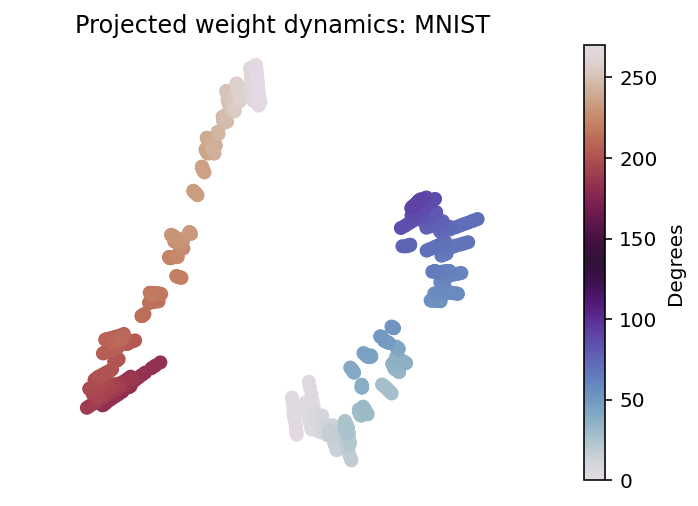

In [23]:
fig, ax = plt.subplots()

degrees_ravel = (degrees[:, None] * np.ones((1, 10))).ravel()

ax.set_title("Projected weight dynamics: MNIST")
im =  ax.scatter(*params_proj.T, cmap="twilight", c=degrees_ravel)
fig.colorbar(im, ax=ax, label="Degrees")

ax.tick_params(axis="both", labelleft=False, labelbottom=False)
ax.axis("equal")
ax.axis("off");

## Training weights

In [318]:
configs_params_flat.shape

(1000, 1033510)

In [24]:
n_components = 60
pca = PCA(n_components=n_components)
params_proj = pca.fit_transform(configs_params_flat)

tcmalloc: large alloc 4134043648 bytes == 0x562fe01ae000 @  0x7f474d446680 0x7f474d467824 0x7f472bb921ed 0x7f472bb92267 0x7f472bbd4c1b 0x7f472bbd4f8a 0x7f472bbccc85 0x7f472bc6e764 0x562b57974a41 0x562b5792ef00 0x562b579b6d2b 0x562b579b7697 0x562b57970687 0x562b579fe7e0 0x562b579e23fd 0x562b5792ef00 0x562b579b78c3 0x562b5792f1a4 0x562b579b6b32 0x562b579b7697 0x562b5792f1a4 0x562b579b6b32 0x562b57a66ddc 0x562b579b7b5b 0x562b57a9c8fe 0x562b57995581 0x562b5792f3be 0x562b579a7d34 0x562b57a013ff 0x562b579a7d34 0x562b57a013ff
tcmalloc: large alloc 4134043648 bytes == 0x562d8099e000 @  0x7f474d446680 0x7f474d467824 0x7f472bb921ed 0x7f472bb92267 0x7f472bbd4c1b 0x7f472bbd4ed8 0x7f472bc86177 0x7f472bc87dec 0x7f472bdcd652 0x562b578d4e88 0x562b57a565d8 0x7f472bc8f0a7 0x562b5796b829 0x562b579fd280 0x562b579b6d2b 0x562b579b7697 0x562b57970687 0x562b579fe7e0 0x562b579b6d2b 0x562b579b7697 0x562b57970687 0x7f472bbc1a74 0x562b57976e88 0x562b57970e4f 0x562b579fc937 0x562b579b6b32 0x562b579b7697 0x562b5792

In [25]:
angle_dict = [{"angle": float(deg)} for deg in degrees]

In [26]:
n_train_subset = 6_000
subset_ix = pd.Series(y_train).sample(n_train_subset, random_state=314)
subset_ix = subset_ix.index.values
subset_ix

array([46242, 52277, 30471, ..., 18692,  3212,   220])

In [75]:
filename = f"training-weights-dynamics.log"
filename = os.path.join(path_logs, filename)

logger.add(filename, rotation="5mb")
logger.warning("Initialising process")

2022-03-17 16:47:28.038 | WARNING  | __main__:<module>:5 - Initialising process


In [28]:
n_train, *elem_dims = X_train.shape
n_configs = len(degrees)

imap = np.ones((n_configs, 1, *elem_dims))
X_train_shift = X_train[subset_ix] * imap
X_train_shift = X_train_shift.reshape(-1, *elem_dims)
X_train_shift.shape

tcmalloc: large alloc 3763200000 bytes == 0x562d8099e000 @  0x7f474d446680 0x7f474d467824 0x7f472bb921ed 0x7f472bb92267 0x7f472bbd4c1b 0x7f472bbd4ed8 0x7f472bc86177 0x7f472bc87dec 0x7f472bdcd652 0x562b578d4e88 0x562b57a565d8 0x7f472bc8eff7 0x562b579c2520 0x562b579fd568 0x562b579b6b32 0x562b57a66ddc 0x562b579b7b5b 0x562b57a9c8fe 0x562b57995581 0x562b5792f3be 0x562b579a7d34 0x562b57a013ff 0x562b579a7d34 0x562b57a013ff 0x562b579a7d34 0x562b579b10a3 0x562b5792f1a4 0x562b579b78c3 0x562b5792f3be 0x562b579b78c3 0x562b5792f1a4


(600000, 28, 28)

In [41]:
degrees_shift = (degrees_ravel[:, None] * np.ones((1, 600))).reshape(-1)

degrees_shift = [{"angle": float(angle)} for angle in degrees_shift] # degrees_shift

X_train_shift = proc_class(X_train_shift, degrees_shift)

In [76]:
np.c_[np.arange(1000), params_proj].reshape(num_cycles, n_configs, -1, order="F")[:, 99, 0]

array([990., 991., 992., 993., 994., 995., 996., 997., 998., 999.])

In [72]:
X_train_shift = X_train_shift.reshape((n_train_subset, n_configs, -1), order="F")
y_train_shift = params_proj.reshape((num_cycles, n_configs, -1), order="F")

In [77]:
X_train_shift.shape

(6000, 100, 784)

In [78]:
y_train_shift.shape

(10, 100, 60)

In [320]:
alpha = 0.01
n_epochs = 100
batch_size = 2000
tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_multi_output_loss_func
weights_model = gendist.models.MLPWeightsV1(n_components)
train_weights = gendist.training.TrainingMeta(weights_model, lossfn, tx)

In [308]:
X_train_shift_jax = jnp.array(X_train_shift)
y_train_shift_jax = jnp.array(y_train_shift)

In [309]:
X_train_shift.shape

(6000, 100, 784)

In [319]:
y_train_shift_jax[[5], ...].shape

(1, 100, 60)

In [321]:
train_output = train_weights.fit(key, X_train_shift_jax, y_train_shift_jax[[5], ...], n_epochs, batch_size)

In [322]:
yhat_train_shift = weights_model.apply(weights_trained, X_train_shift_jax)
yhat_train_shift.shape

(6000, 100, 60)

In [323]:
yhat_train_shift[:, 0, :3]

DeviceArray([[  15.88155  , -112.93128  ,  141.807    ],
             [  35.202366 , -122.11552  ,  121.712616 ],
             [  11.025028 , -104.52897  ,  145.01349  ],
             ...,
             [   6.127083 ,  -96.81982  ,  103.71644  ],
             [  -7.0829315,  -89.79923  ,   84.37324  ],
             [  13.435566 ,  -50.588814 ,  100.1075   ]], dtype=float32)

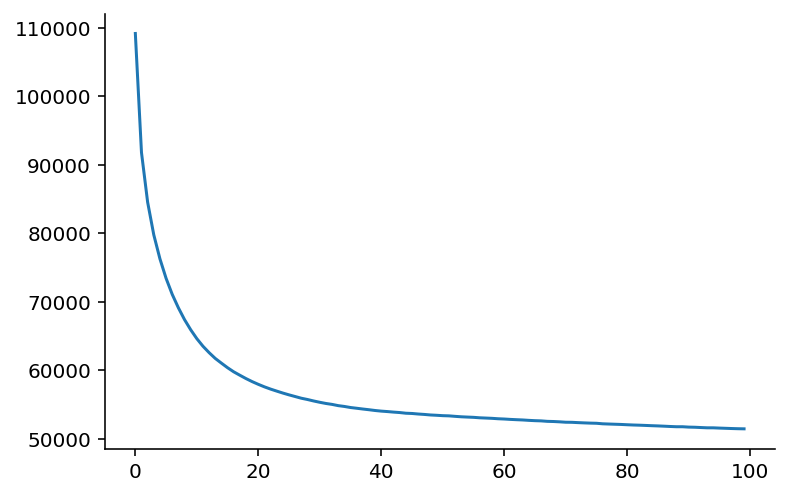

In [324]:
weights_trained = train_output["params"]
losses = train_output["losses"]

plt.plot(losses)

In [325]:
losses.min()

DeviceArray(51440.242, dtype=float32)

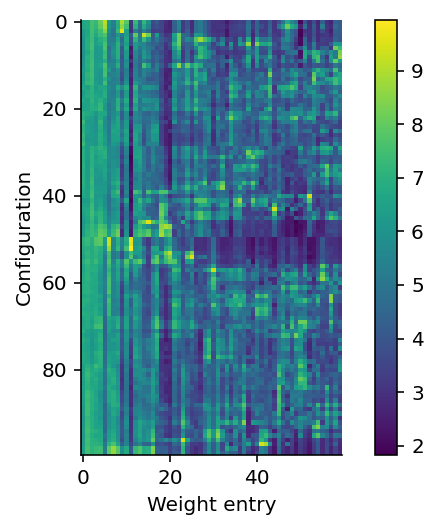

In [236]:
errs = np.power((weights_model.apply(weights_trained, X_train_shift_jax) - y_train_shift_jax[[0], :]), 2).mean(axis=0)
plt.imshow(jnp.log(errs))
plt.ylabel("Configuration")
plt.xlabel("Weight entry")
plt.colorbar()

In [132]:
from itertools import product

In [280]:
N, M, K = 4, 3, 1
tot_values = N * M * K
batch_ix = np.arange(tot_values)
batch_ix % K

X_obs = np.array([f"x({n},{m})" for n, m in product(range(N), range(M))]).reshape(N, M)
w_obs = np.array([f"w({k},{m})" for k, m in product(range(K), range(M))]).reshape(K, M)

In [281]:
X_obs

array([['x(0,0)', 'x(0,1)', 'x(0,2)'],
       ['x(1,0)', 'x(1,1)', 'x(1,2)'],
       ['x(2,0)', 'x(2,1)', 'x(2,2)'],
       ['x(3,0)', 'x(3,1)', 'x(3,2)']], dtype='<U6')

In [282]:
w_obs

array([['w(0,0)', 'w(0,1)', 'w(0,2)']], dtype='<U6')

In [283]:
x_batch_str = X_obs[batch_ix % N, batch_ix // (N * K)]
w_batch_str = w_obs[(batch_ix // N) % K, batch_ix // (N * K)]

for x, w in zip(x_batch_str, w_batch_str):
    print(x, w)

x(0,0) w(0,0)
x(1,0) w(0,0)
x(2,0) w(0,0)
x(3,0) w(0,0)
x(0,1) w(0,1)
x(1,1) w(0,1)
x(2,1) w(0,1)
x(3,1) w(0,1)
x(0,2) w(0,2)
x(1,2) w(0,2)
x(2,2) w(0,2)
x(3,2) w(0,2)


In [163]:
jnp.power(weights_model.apply(weights_trained, X_train_shift) - y_train_shift, 2).mean()

DeviceArray(11.283924, dtype=float32)

In [254]:
filename = "projected-weights.params"
filename = os.path.join(path_output, filename)

with open(filename, "wb") as f:
    bytes_params = serialization.to_bytes(weights_trained)
    f.write(bytes_params)

# Proxy zero-shot learning

In [255]:
angle_test = np.linspace(0, 360, 100)

In [23]:
with open(observed_space_filename, "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

In [24]:
with open("weights-dynamics-rotation-trench.params", "rb") as f:
    weights_trained = weights_model.init(jax.random.PRNGKey(314), jnp.ones((1, 28 ** 2)))
    weights_trained = serialization.from_bytes(weights_trained, f.read())

In [256]:
logger.remove()
filename = f"trench-test-c{n_components}.log"
filename = os.path.join(path_logs, filename)
logger.add(filename, rotation="5mb")

1

In [257]:
def predict_shifted_dataset(ix_seed, X_batch, processor, config, wmodel, wparams, dmodel, proj, fn_reconstruct):
    """
    Parameters
    ----------
    ix_seed: array
    X_batch: array
    ...
    wmodel: model for the latent space
    wparams: trained weights for the latent space
    dmodel: model for the observed space
    dparams: trained model for the observed weights
    """
    x_seed = X_batch[ix]
    x_shift = processor.process_single(x_seed, **config).ravel()
    predicted_weights = wmodel.apply(wparams, x_shift)
    predicted_weights = proj.inverse_transform(predicted_weights)
    predicted_weights = fn_reconstruct(predicted_weights)
    
    X_batch_shift = processor(X_batch, config)
    y_batch_hat = dmodel.apply(predicted_weights, X_batch_shift)
    
    return y_batch_hat

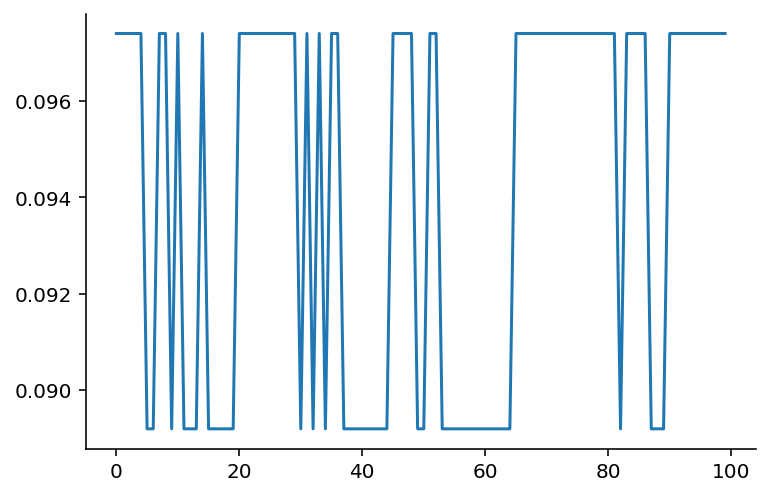

In [264]:
plt.plot(accuracy_configs_learned)

In [260]:
ix = 4
accuracy_configs_learned = []
predicted_weights_array = []

for angle in tqdm(angle_test):
    config = {"angle": float(angle)}
    
    y_test_hat = predict_shifted_dataset(ix, X_test, proc_class, config,
                                         weights_model, weights_trained, model, pca, fn_recontruct_params)
    y_test_hat = y_test_hat.argmax(axis=1)
    
    accuracy_learned = (y_test_hat == y_test).mean()
    accuracy_configs_learned.append(accuracy_learned.item())
    
    # predicted_weights_array.append(predicted_weights)
    
    logger.info(f"{angle=:0.4f} | {accuracy_learned=:0.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

https://symbolize.stripped_domain/r/?trace=55d2fbf5b5c0,7f3bc72283bf,7f392d5ac4ef,55d2fc118c1f&map= 
*** SIGTERM received by PID 2339768 (TID 2339768) on cpu 31 from PID 2236720; stack trace: ***
PC: @     0x55d2fbf5b5c0  (unknown)  PyObject_SetAttr
    @     0x7f3bb6ad67fa        992  (unknown)
    @     0x7f3bc72283c0  (unknown)  (unknown)
    @     0x7f392d5ac4f0  1811511240  (unknown)
    @     0x55d2fc118c20  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=55d2fbf5b5c0,7f3bb6ad67f9,7f3bc72283bf,7f392d5ac4ef,55d2fc118c1f&map=7a511a57244151c993b16b37978e7ed7:7f3ba80fe000-7f3bb6e40d50 
E0318 17:04:32.452300 2339768 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0318 17:04:32.508304 2339768 process_state.cc:770] RAW: Raising signal 15 with default behavior
https://symbolize.stripped_domain/r/?trace=55d2fbeb6700,7f3bc72283bf,55d2fcbc5fff&map= 
*** SIGTERM received by PID 2347413 (TID 2347413) on cpu 5 from PID 2236720; stack trace: ***
PC: @   

In [ ]:
accuracy_configs_learned = []
predicted_weights_array = []

ixs = [0, 1, 2, 3, 4]
for angle in tqdm(angle_test):
    config = {"angle": float(angle)}
    
    acc_dict = {}
    params_dict = {}
    for ix in ixs:
        y_test_hat = predict_shifted_dataset(ix, X_test, proc_class, config,
                                             weights_model, weights_trained, model, pca, fn_recontruct_params)
        y_test_hat = y_test_hat.argmax(axis=1)
        accuracy_learned = (y_test_hat == y_test).mean().item()
        acc_dict[ix] = accuracy_learned
        
    accuracy_configs_learned.append(acc_dict)
    
    logger_row = "|".join([format(v, "0.2%") for v in acc_dict.values()])
    logger_row = f"{angle=:0.4f} | " + logger_row 
    
    logger.info(logger_row)

  0%|          | 0/100 [00:00<?, ?it/s]

https://symbolize.stripped_domain/r/?trace=7f36d8b81a65,7f36d8b833bf&map= 
*** SIGTERM received by PID 2028279 (TID 2028279) on cpu 31 from PID 1951196; stack trace: ***
https://symbolize.stripped_domain/r/?trace=7f36d8b81a65,7f36d8b833bf&map= 
*** SIGTERM received by PID 2028269 (TID 2028269) on cpu 84 from PID 1951196; stack trace: ***
PC: @     0x7f36d8b81a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f36c6e317fa        992  (unknown)
    @     0x7f36d8b833c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=7f36d8b81a65,7f36c6e317f9,7f36d8b833bf&map=7a511a57244151c993b16b37978e7ed7:7f36b8459000-7f36c719bd50 
E0315 13:27:38.786079 2028279 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
PC: @     0x7f36d8b81a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f36c6e317fa        992  (unknown)
    @     0x7f36d8b833c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domai

In [ ]:
acc_df = pd.DataFrame(accuracy_configs_learned, index=angle_test, columns=y_test[ixs])
acc_df.plot()

plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.axvspan(90, 180, alpha=0.2, color="tab:gray")

plt.axvline(x=270, c="tab:gray", linestyle="--")
plt.axvline(x=360, c="tab:gray", linestyle="--")
plt.axvspan(270, 360, alpha=0.2, color="tab:gray")


We evaluate the predicted weights on the training dataset

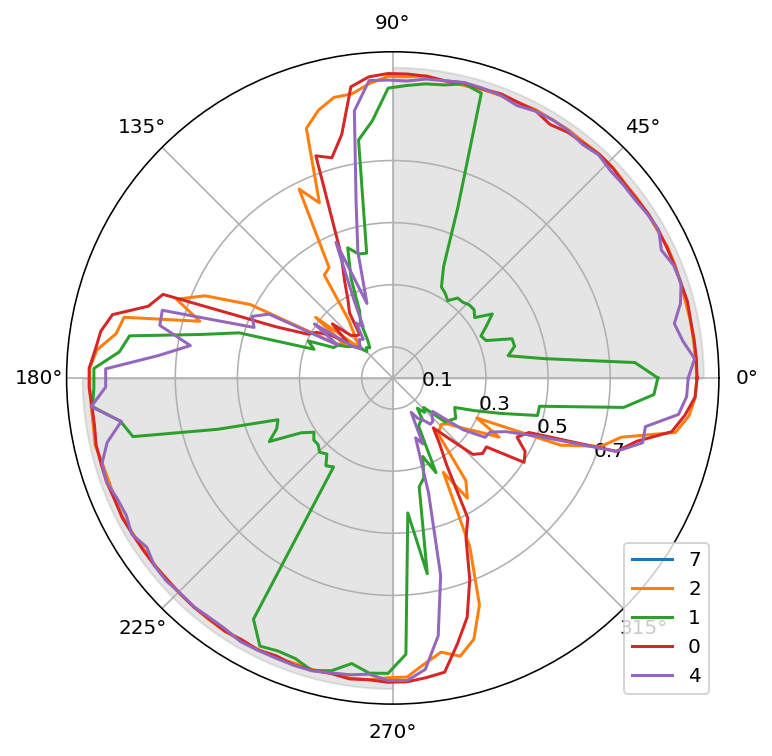

In [247]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 6))
acc_df.set_index(acc_df.index.values * np.pi / 180).plot(ax=ax)
ax.set_rticks([0.1, 0.3, 0.5, 0.7])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.fill_between(np.linspace(0, np.pi/2, 100), 0, 1.0, alpha=0.2, color="tab:gray")
ax.fill_between(np.linspace(np.pi, 3 * np.pi/2, 100), 0, 1.0, alpha=0.2, color="tab:gray")
plt.legend(loc="lower right")

ax.grid(True)